2064it [37:00,  1.08s/it]

1 / 512 / 512
pt_bpp:  [0.04857154 0.04674372 0.03186241 0.02490902 0.02186425 0.0160078 ]
pt_psnr:  [59.73145  55.27617  56.66549  55.02037  51.606537 51.289482]
pt_mssim:  [0.99756804 0.99532679 0.99474578 0.99007912 0.99048218 0.99047563]
pt_mse:  [ 5731.7075 18151.32   11262.903  19050.06   34901.06   44258.83  ]
ft_bpp:  0.0031216633560265912
ft_psnr:  63.70394
ft_mssim:  0.9989381640887568
ft_mse:  2642.5527


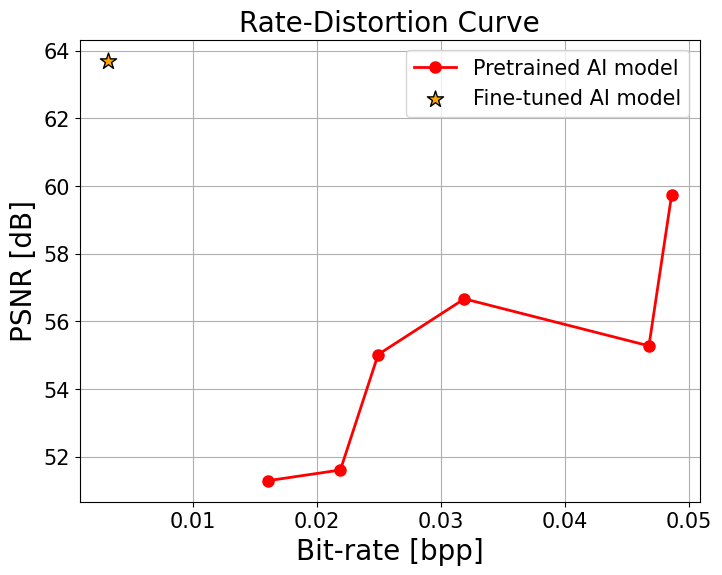

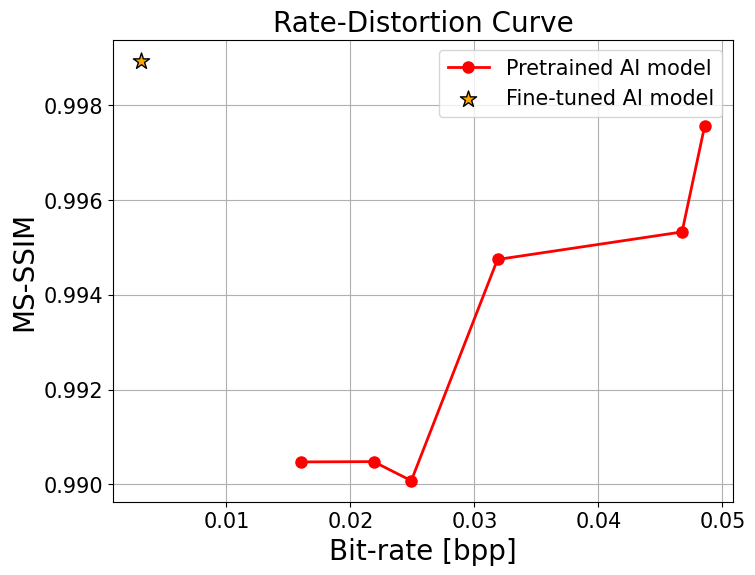

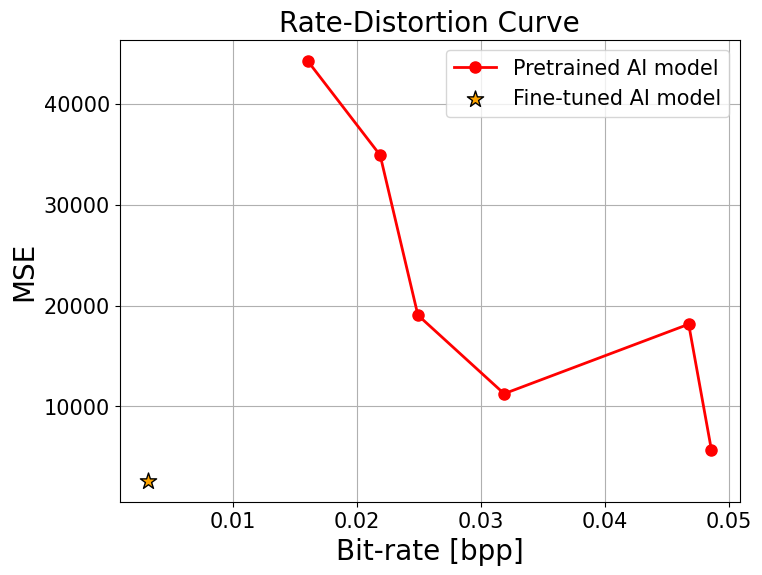

In [1]:
# test pretrained model, finetuned model
from dataset import get_datasets
from transforms import get_ori_transform, get_train_transform
from compressai.zoo import cheng2020_attn
from torch.utils.data import DataLoader
from metric import calculate_ms_ssim, calculate_psnr
import torch
import numpy as np
import math
# from skimage.transform import rescale
# from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import matplotlib.pyplot as plt
from config import device

def unpreprocess(maxv_log, minv_log, res_img):
    res_img = res_img[0][0] # (B,3,H,W) -> (H,W)
    res_img = res_img * (maxv_log - minv_log) + minv_log
    res_img = torch.expm1(res_img)
    return res_img

def load_file_list(txt_path):
    with open(txt_path, 'r') as f:
        return [line.strip() for line in f.readlines()]

def calculate_bits(likelihood):
    bpp_loss = sum((torch.log(likelihoods).sum() / (-math.log(2)))for likelihoods in likelihood.values())
    return bpp_loss.item()

def compute_bpp(strings, num_pixels):
    """
    압축된 비트스트림(strings)과 총 픽셀 수를 기반으로 BPP(Bits Per Pixel)를 계산합니다.

    Args:
        strings (list[list[bytes]]): 압축된 비트스트림을 포함하는 리스트.
                                     예: [[y_string_0, y_string_1, ...], [z_string_0, ...]]
                                     각 내부 리스트는 하나의 압축된 텐서에 해당합니다.
        num_pixels (int): 원본 이미지의 총 픽셀 수 (높이 * 너비).

    Returns:
        float: 계산된 BPP 값.
    """
    # 총 비트 수를 저장할 변수 초기화
    num_bits = 0
    print(strings)
    # strings 리스트의 각 요소는 y_strings, z_strings 등 압축된 텐서에 해당합니다.
    # 각 텐서는 여러 개의 바이트 시퀀스로 분할될 수 있습니다 (예: 패치 기반 압축).
    for s in strings:
        # 각 바이트 시퀀스의 길이를 더하여 총 바이트 수를 얻습니다.
        for i in range(len(s)):
            num_bits += len(s[i]) * 8  # 바이트를 비트로 변환 (1바이트 = 8비트)

    # 총 비트 수를 픽셀 수로 나누어 BPP를 계산합니다.
    # num_pixels가 0일 경우 ZeroDivisionError를 방지
    if num_pixels == 0:
        return 0.0
    return num_bits / num_pixels

data1024_filename = 'data1024lst.txt'

# fine tuned model 갖고오기
# 1. 모델 선언 (이때 .to(device)는 나중에 하는 게 좋음)
model_finetuned = cheng2020_attn(pretrained=False, quality=6)
# 2. 학습된 가중치 불러오기
checkpoint = torch.load("best_model4.pth", map_location=device)
model_finetuned.load_state_dict(checkpoint, strict=True)
# 3. 모델을 GPU로 올리기
model_finetuned = model_finetuned.to(device)
# 4. 평가 모드 설정
model_finetuned.eval()

# pretrained model 갖고오기
model_pretrained6 = cheng2020_attn(pretrained=True, quality=6).to(device).eval()
model_pretrained5 = cheng2020_attn(pretrained=True, quality=5).to(device).eval()
model_pretrained4 = cheng2020_attn(pretrained=True, quality=4).to(device).eval()
model_pretrained3 = cheng2020_attn(pretrained=True, quality=3).to(device).eval()
model_pretrained2 = cheng2020_attn(pretrained=True, quality=2).to(device).eval()
model_pretrained1 = cheng2020_attn(pretrained=True, quality=1).to(device).eval()

# test data 갖고오기
transform = get_train_transform()
ori_transform = get_ori_transform()

_, _, test_set = get_datasets(data1024_filename ,transform=transform)

_, _, _test_set = get_datasets(data1024_filename ,transform=ori_transform)

test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
_test_loader = DataLoader(_test_set, batch_size=1, shuffle=False)

total_bits_pt6 = 0
total_bits_pt5 = 0
total_bits_pt4 = 0
total_bits_pt3 = 0
total_bits_pt2 = 0
total_bits_pt1 = 0
total_bits_ft = 0

total_psnr_pt6 = 0
total_psnr_pt5 = 0
total_psnr_pt4 = 0
total_psnr_pt3 = 0
total_psnr_pt2 = 0
total_psnr_pt1 = 0
total_psnr_ft = 0

total_mssim_pt6 = 0
total_mssim_pt5 = 0
total_mssim_pt4 = 0
total_mssim_pt3 = 0
total_mssim_pt2 = 0
total_mssim_pt1 = 0
total_mssim_ft = 0

total_mse_pt6 = 0
total_mse_pt5 = 0
total_mse_pt4 = 0
total_mse_pt3 = 0
total_mse_pt2 = 0
total_mse_pt1 = 0
total_mse_ft = 0


i = 0 ###########
with torch.no_grad():
    for (input_pr, input_or) in tqdm(zip(test_loader, _test_loader)):
        i += 1
        input_or = input_or.to(device, non_blocking=True)
        input_pr = input_pr.to(device, non_blocking=True)

        # pretrained
        output_pt6 = model_pretrained6(input_pr)
        output_pt5 = model_pretrained5(input_pr)
        output_pt4 = model_pretrained4(input_pr)
        output_pt3 = model_pretrained3(input_pr)
        output_pt2 = model_pretrained2(input_pr)
        output_pt1 = model_pretrained1(input_pr)

        # finetuned
        output_ft = model_finetuned(input_pr) 

        pt6_xhat, pt6_likelihoods = output_pt6['x_hat'], output_pt6['likelihoods']
        pt5_xhat, pt5_likelihoods = output_pt5['x_hat'], output_pt5['likelihoods']
        pt4_xhat, pt4_likelihoods = output_pt4['x_hat'], output_pt4['likelihoods']
        pt3_xhat, pt3_likelihoods = output_pt3['x_hat'], output_pt3['likelihoods']
        pt2_xhat, pt2_likelihoods = output_pt2['x_hat'], output_pt2['likelihoods']
        pt1_xhat, pt1_likelihoods = output_pt1['x_hat'], output_pt1['likelihoods']
        ft_xhat, ft_likelihoods = output_ft['x_hat'], output_ft['likelihoods']
        # float32, [0,1]

        log_ori = torch.log1p(torch.clamp(input_or,min=0))
        maxv_log = log_ori.max()
        minv_log = log_ori.min()

        # unpreprocess
        pt6_unpr = unpreprocess(maxv_log, minv_log, pt6_xhat).cpu().numpy()
        pt5_unpr = unpreprocess(maxv_log, minv_log, pt5_xhat).cpu().numpy()
        pt4_unpr = unpreprocess(maxv_log, minv_log, pt4_xhat).cpu().numpy()
        pt3_unpr = unpreprocess(maxv_log, minv_log, pt3_xhat).cpu().numpy()
        pt2_unpr = unpreprocess(maxv_log, minv_log, pt2_xhat).cpu().numpy()
        pt1_unpr = unpreprocess(maxv_log, minv_log, pt1_xhat).cpu().numpy()
        ft_unpr = unpreprocess(maxv_log, minv_log, ft_xhat).cpu().numpy() # (1024, 1024) [0,32767]

        # input_or: (1,1,1024,1024) -> (1024,1024)
        input_or = input_or.squeeze().cpu().numpy()

        # cal bbp
        temp_pt6_bits = calculate_bits(pt6_likelihoods)
        temp_pt5_bits = calculate_bits(pt5_likelihoods)
        temp_pt4_bits = calculate_bits(pt4_likelihoods)
        temp_pt3_bits = calculate_bits(pt3_likelihoods)
        temp_pt2_bits = calculate_bits(pt2_likelihoods)
        temp_pt1_bits = calculate_bits(pt1_likelihoods)
        temp_ft_bits = calculate_bits(ft_likelihoods)

        total_bits_pt6 += temp_pt6_bits
        total_bits_pt5 += temp_pt5_bits
        total_bits_pt4 += temp_pt4_bits
        total_bits_pt3 += temp_pt3_bits
        total_bits_pt2 += temp_pt2_bits
        total_bits_pt1 += temp_pt1_bits
        total_bits_ft += temp_ft_bits
        
        # cal psnr
        temp_pt6_psnr = calculate_psnr(input_or, pt6_unpr)
        temp_pt5_psnr = calculate_psnr(input_or, pt5_unpr)
        temp_pt4_psnr = calculate_psnr(input_or, pt4_unpr)
        temp_pt3_psnr = calculate_psnr(input_or, pt3_unpr)
        temp_pt2_psnr = calculate_psnr(input_or, pt2_unpr)
        temp_pt1_psnr = calculate_psnr(input_or, pt1_unpr)
        temp_ft_psnr = calculate_psnr(input_or, ft_unpr)

        total_psnr_pt6 += temp_pt6_psnr
        total_psnr_pt5 += temp_pt5_psnr
        total_psnr_pt4 += temp_pt4_psnr
        total_psnr_pt3 += temp_pt3_psnr
        total_psnr_pt2 += temp_pt2_psnr
        total_psnr_pt1 += temp_pt1_psnr
        total_psnr_ft += temp_ft_psnr

        # cal ms-ssim
        temp_pt6_mssim = calculate_ms_ssim(input_or, pt6_unpr)
        temp_pt5_mssim = calculate_ms_ssim(input_or, pt5_unpr)
        temp_pt4_mssim = calculate_ms_ssim(input_or, pt4_unpr)
        temp_pt3_mssim = calculate_ms_ssim(input_or, pt3_unpr)
        temp_pt2_mssim = calculate_ms_ssim(input_or, pt2_unpr)
        temp_pt1_mssim = calculate_ms_ssim(input_or, pt1_unpr)
        temp_ft_mssim = calculate_ms_ssim(input_or, ft_unpr)

        total_mssim_pt6 += temp_pt6_mssim
        total_mssim_pt5 += temp_pt5_mssim
        total_mssim_pt4 += temp_pt4_mssim
        total_mssim_pt3 += temp_pt3_mssim
        total_mssim_pt2 += temp_pt2_mssim
        total_mssim_pt1 += temp_pt1_mssim
        total_mssim_ft += temp_ft_mssim

        # cal mse
        temp_pt6_mse = np.mean((input_or - pt6_unpr) ** 2)
        temp_pt5_mse = np.mean((input_or - pt5_unpr) ** 2)
        temp_pt4_mse = np.mean((input_or - pt4_unpr) ** 2)
        temp_pt3_mse = np.mean((input_or - pt3_unpr) ** 2)
        temp_pt2_mse = np.mean((input_or - pt2_unpr) ** 2)
        temp_pt1_mse = np.mean((input_or - pt1_unpr) ** 2)
        temp_ft_mse = np.mean((input_or - ft_unpr) ** 2)   

        total_mse_pt6 += temp_pt6_mse
        total_mse_pt5 += temp_pt5_mse
        total_mse_pt4 += temp_pt4_mse
        total_mse_pt3 += temp_pt3_mse
        total_mse_pt2 += temp_pt2_mse
        total_mse_pt1 += temp_pt1_mse
        total_mse_ft += temp_ft_mse   

        # if i >= 3:
        #     break

        

# totla bits/ counts
img = next(iter(_test_loader))
N,_,H,W = img.size()
print(N,"/",H,"/",W)
num_pixels = N*H*W
# count = len(test_loader)
count = i

# plt.figure(figsize=(10,7))
# plt.title("ft_likelihoods[y]")
# plt.hist(ft_likelihoods['y'].cpu().numpy().ravel(),bins=100,density=True)
# plt.legend()
# plt.show()

# plt.figure(figsize=(10,7))
# plt.title("ft_likelihoods[z]")
# plt.hist(ft_likelihoods['z'].cpu().numpy().ravel(),bins=100,density=True)
# plt.legend()
# plt.show()

# plt.figure(figsize=(12,8))
# plt.hist(pt6_likelihoods['y'].cpu().numpy().ravel(),bins=100,density=True)
# plt.show()

pt6_bpp = total_bits_pt6/count/num_pixels
pt5_bpp = total_bits_pt5/count/num_pixels
pt4_bpp = total_bits_pt4/count/num_pixels
pt3_bpp = total_bits_pt3/count/num_pixels
pt2_bpp = total_bits_pt2/count/num_pixels
pt1_bpp = total_bits_pt1/count/num_pixels
ft_bpp = total_bits_ft/count/num_pixels

pt6_psnr = total_psnr_pt6/count
pt5_psnr = total_psnr_pt5/count
pt4_psnr = total_psnr_pt4/count
pt3_psnr = total_psnr_pt3/count
pt2_psnr = total_psnr_pt2/count
pt1_psnr = total_psnr_pt1/count
ft_psnr = total_psnr_ft/count

pt6_mssim = total_mssim_pt6/count
pt5_mssim = total_mssim_pt5/count
pt4_mssim = total_mssim_pt4/count
pt3_mssim = total_mssim_pt3/count
pt2_mssim = total_mssim_pt2/count
pt1_mssim = total_mssim_pt1/count
ft_mssim = total_mssim_ft/count

pt6_mse = total_mse_pt6/count
pt5_mse = total_mse_pt5/count
pt4_mse = total_mse_pt4/count
pt3_mse = total_mse_pt3/count
pt2_mse = total_mse_pt2/count
pt1_mse = total_mse_pt1/count
ft_mse = total_mse_ft/count


pt_bpp_lst = np.array([pt6_bpp, pt5_bpp, pt4_bpp, pt3_bpp, pt2_bpp, pt1_bpp])
pt_psnr_lst = np.array([pt6_psnr, pt5_psnr, pt4_psnr, pt3_psnr, pt2_psnr, pt1_psnr])
pt_mssim_lst = np.array([pt6_mssim, pt5_mssim, pt4_mssim, pt3_mssim, pt2_mssim, pt1_mssim])
pt_mse_lst = np.array([pt6_mse, pt5_mse, pt4_mse, pt3_mse, pt2_mse, pt1_mse])

print("pt_bpp: ",pt_bpp_lst)
print("pt_psnr: ",pt_psnr_lst)
print("pt_mssim: ",pt_mssim_lst)
print("pt_mse: ",pt_mse_lst)
print("ft_bpp: ",ft_bpp)
print("ft_psnr: ",ft_psnr)
print("ft_mssim: ",ft_mssim)
print("ft_mse: ",ft_mse)



plt.figure(figsize=(8, 6))
plt.plot(pt_bpp_lst, pt_psnr_lst, 'red', linewidth=2, marker='o', markersize=8, label='Pretrained AI model')
plt.scatter(ft_bpp, ft_psnr, s=150, c='orange', marker='*', label='Fine-tuned AI model', zorder=2, edgecolor='black')
plt.xlabel('Bit-rate [bpp]', fontsize=20)
plt.ylabel('PSNR [dB]', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Rate-Distortion Curve', fontsize=20)
plt.grid(True)
plt.legend(fontsize=15)
# plt.savefig('RD_curve_psnr.png')

plt.figure(figsize=(8, 6))
plt.plot(pt_bpp_lst, pt_mssim_lst, 'red', linewidth=2, marker='o', markersize=8, label='Pretrained AI model')
plt.scatter(ft_bpp, ft_mssim, s=150, c='orange', marker='*', label='Fine-tuned AI model', zorder=2, edgecolor='black')
plt.xlabel('Bit-rate [bpp]', fontsize=20)
plt.ylabel('MS-SSIM', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Rate-Distortion Curve', fontsize=20)
plt.grid(True)
plt.legend(fontsize=15)
# plt.savefig('RD_curve_ms_ssim.png')

plt.figure(figsize=(8, 6))
plt.plot(pt_bpp_lst, pt_mse_lst, 'red', linewidth=2, marker='o', markersize=8, label='Pretrained AI model')
plt.scatter(ft_bpp, ft_mse, s=150, c='orange', marker='*', label='Fine-tuned AI model', zorder=2, edgecolor='black')
plt.xlabel('Bit-rate [bpp]', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Rate-Distortion Curve', fontsize=20)
plt.grid(True)
plt.legend(fontsize=15)

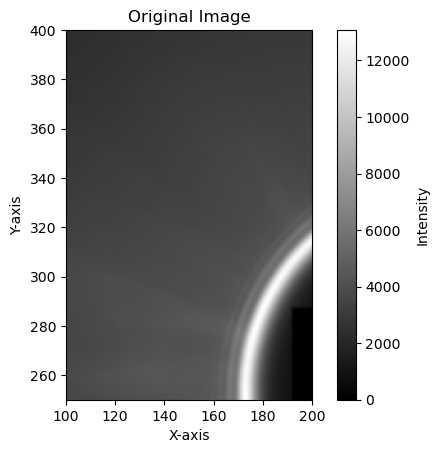

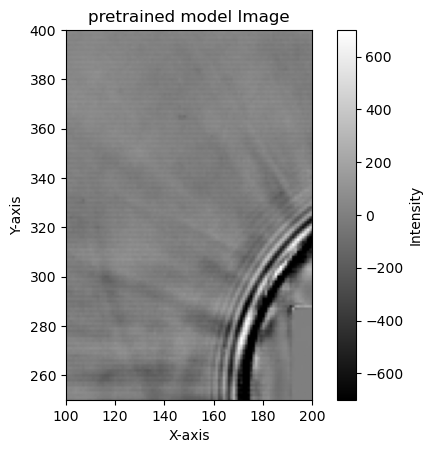

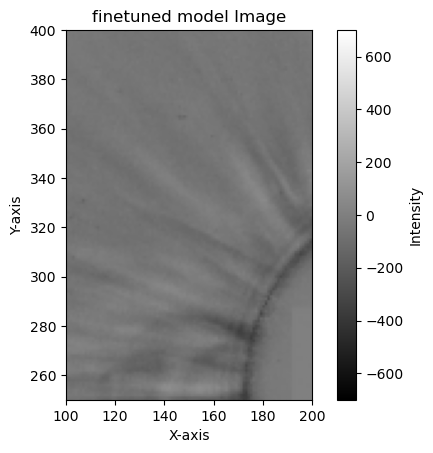

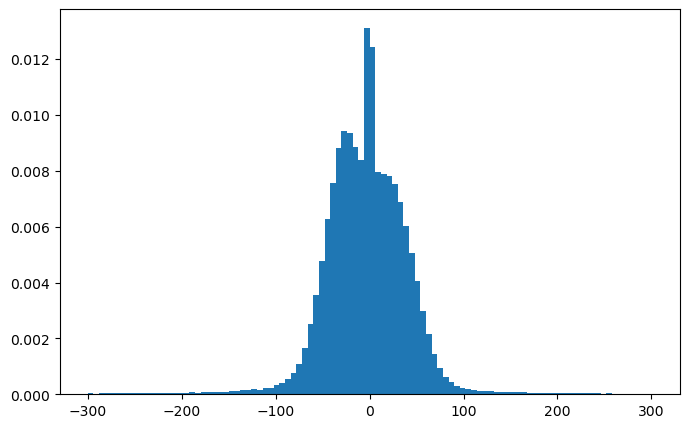

pt std: 79.693695


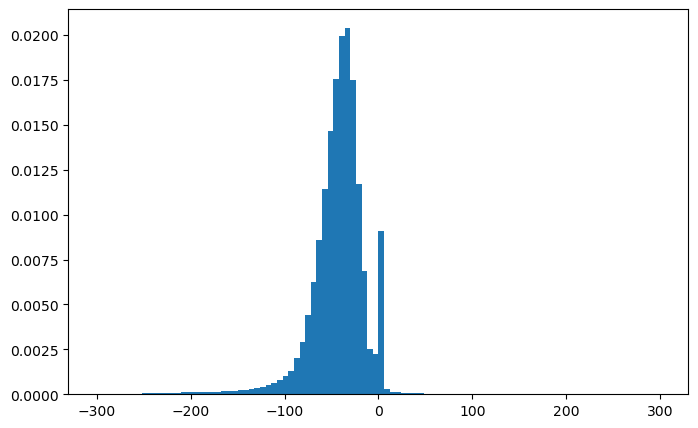

ft std: 30.743979


In [2]:
# original, pretrained, finetuned 1장씩 비교
# pretrained model 6
from compressai.zoo import cheng2020_attn
from matplotlib import pyplot as plt
import torch
from dataset import get_datasets
from transforms import get_ori_transform, get_train_transform
from config import device
import numpy as np

def unpreprocess(maxv_log, minv_log, res_img):
    res_img = res_img[0][0] # (B,3,H,W) -> (H,W)
    res_img = res_img * (maxv_log - minv_log) + minv_log
    res_img = torch.expm1(res_img)
    return res_img

ori_transform = get_ori_transform()
transform = get_train_transform()
data1024_filename = 'data1024lst.txt'

_, _, test_set = get_datasets(data1024_filename, transform=transform)
_, _, _test_set = get_datasets(data1024_filename, transform=ori_transform)

model_pt6= cheng2020_attn(pretrained=True, quality=6).to(device).eval()

# fine tuned model
# 1. 모델 선언 (이때 .to(device)는 나중에 하는 게 좋음)
# 1. 모델 선언 (이때 .to(device)는 나중에 하는 게 좋음)
model_finetuned = cheng2020_attn(pretrained=False, quality=6)
# 2. 학습된 가중치 불러오기
checkpoint = torch.load("best_model4.pth", map_location=device)
model_finetuned.load_state_dict(checkpoint, strict=True)
# 3. 모델을 GPU로 올리기
model_finetuned = model_finetuned.to(device)
# 4. 평가 모드 설정
model_finetuned.eval()

idx = 1
img_or = _test_set[idx][0] # original
log_ori = torch.log1p(torch.clamp(img_or,min=0))
maxv_log = log_ori.max()
minv_log = log_ori.min()

output_pt6 = model_pt6(test_set[idx].unsqueeze(0).to(device))
output_ft = model_finetuned(test_set[idx].unsqueeze(0).to(device))

img_pt6 =unpreprocess(maxv_log=maxv_log, minv_log=minv_log, res_img=output_pt6['x_hat']).squeeze(0).cpu() # pretrained
img_ft = unpreprocess(maxv_log=maxv_log, minv_log=minv_log, res_img=output_ft['x_hat']).squeeze(0).cpu() # finetuned


# 이미지 확대
xlim = [100,200]
ylim = [250,400]
plt.imshow(img_or.cpu().numpy(),origin='lower', cmap='gray')
plt.xlim(xlim)
plt.ylim(ylim)
plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('Original Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

pt_ori = img_pt6.detach().numpy() - img_or.cpu().numpy()
plt.imshow(pt_ori, origin='lower', cmap='gray', vmax=700,vmin=-700)
plt.xlim(xlim)
plt.ylim(ylim)
plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('pretrained model Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

ft_ori = img_ft.detach().numpy() - img_or.cpu().numpy()
plt.imshow(ft_ori,origin='lower', cmap='gray', vmax=700,vmin=-700)
plt.xlim(xlim)
plt.ylim(ylim)
plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('finetuned model Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(pt_ori.ravel(), density = True, bins= 100, range=(-300,300))
plt.show()
print("pt std:", np.std(pt_ori))

plt.figure(figsize=(8,5))
plt.hist(ft_ori.ravel(), density = True, bins= 100, range=(-300,300))
plt.show()
print("ft std:", np.std(ft_ori))

In [ ]:
# 이미지 확대
xlim = [200,400]
ylim = [450,800]

fig, axs = plt.subplots(1, 3, figsize=(15, 6))  # figsize는 그림 크기 조절용

img0 = axs[0].imshow(img_or.cpu().numpy(),origin='lower', cmap='gray')
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
# axs[0].colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
axs[0].set_title('Original Image')
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')



img1 = axs[1].imshow(img_pt6.detach().numpy(),origin='lower', cmap='gray')
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
# axs[1].colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
axs[1].set_title('pretrained model Image')
axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Y-axis')


img2 = axs[2].imshow(img_ft.detach().numpy(),origin='lower', cmap='gray')
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)
# axs[2].colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
axs[2].set_title('finetuned model Image')
axs[2].set_xlabel('X-axis')
axs[2].set_ylabel('Y-axis')


# 각 서브플롯마다 컬러바 추가
fig.colorbar(img0, ax=axs[0])
fig.colorbar(img1, ax=axs[1])
fig.colorbar(img2, ax=axs[2])

plt.tight_layout()
plt.show()

(512, 512)


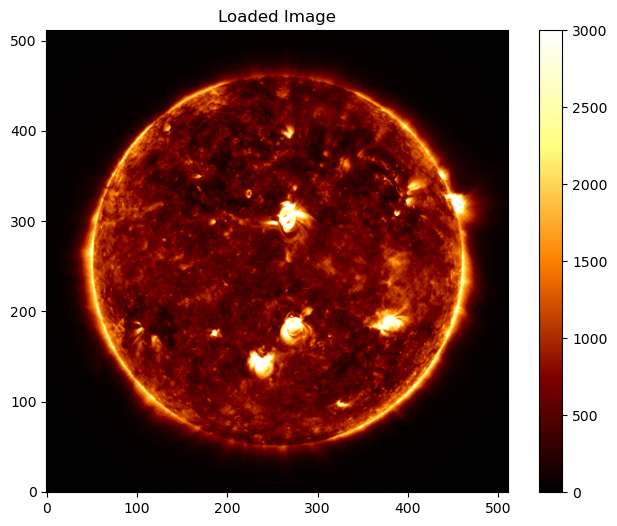

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# NPY 파일에서 데이터 로드
loaded_array = np.load('./SDOML_171_zip/06/01/AIA20100601_1806_0171.npz')
img = loaded_array['x']  # 'x' 키로 이미지 데이터 접근
print(img.shape)  # 이미지의 shape 출력
plt.figure(figsize=(8, 6))
plt.imshow(img, cmap='afmhot',origin='lower',vmin=0, vmax=3000)
plt.colorbar()
plt.title('Loaded Image')
plt.show()

AIA20100601_1806_0171.npz


0it [00:00, ?it/s]

<built-in method size of Tensor object at 0x7a2d20a32620>


1it [00:01,  1.87s/it]

<built-in method size of Tensor object at 0x7a2d5b2fdc20>


1it [00:03,  3.08s/it]

<built-in method size of Tensor object at 0x7a2d5b250e60>
1 / 512 / 512
262144
pt_bpp:  [0.16523139 0.11144668 0.07571066 0.04914508 0.03292743 0.02125641]
pt_psnr:  [60.78617  59.09945  57.909897 56.59644  53.9767   54.199425]
pt_mssim:  [0.99272403 0.98826856 0.98349519 0.97681602 0.95813325 0.95634291]
pt_mse:  [ 3584.0254  5284.626   6950.917   9404.014  17190.785  16331.092 ]
ft_bpp:  0.2503312677145004
ft_psnr:  55.2314
ft_mssim:  0.97155104589228
ft_mse:  12876.805


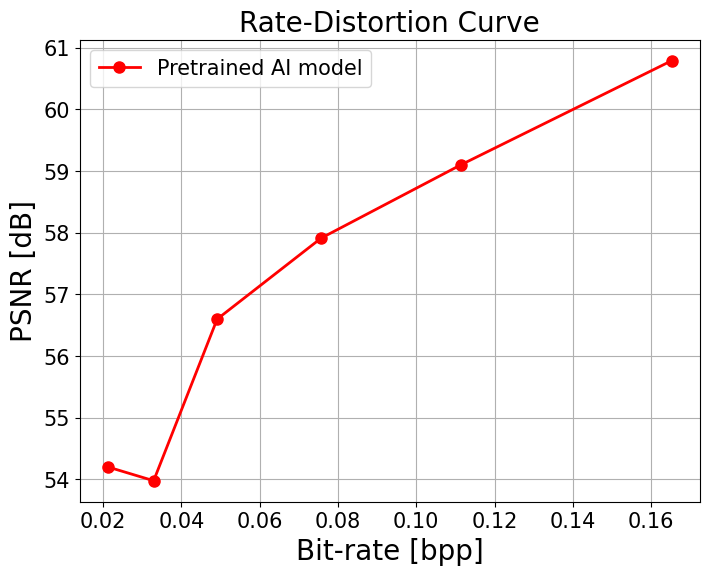

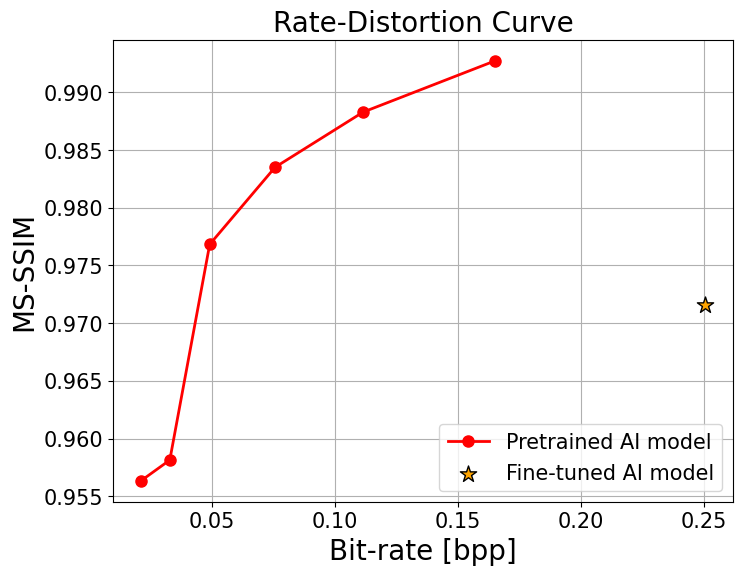

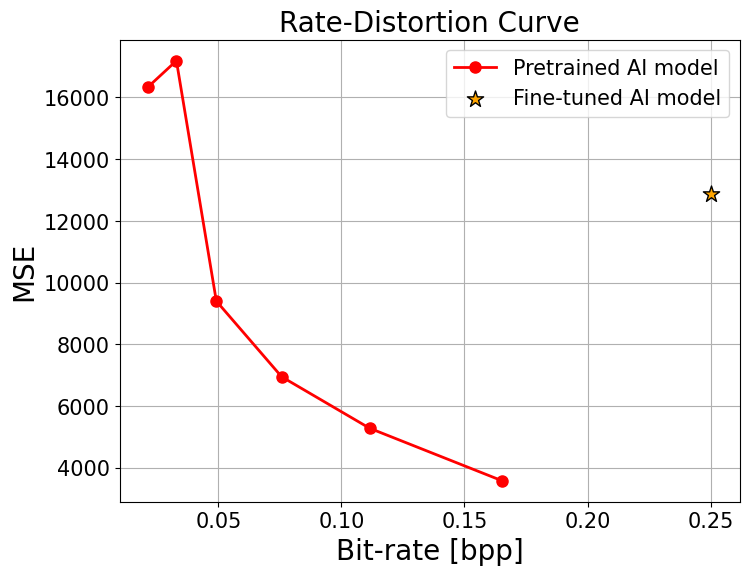

In [1]:
# 171데이터 적용

from dataset import get_datasets
from transforms import get_test_transform, get_ori_transform
from compressai.zoo import cheng2020_attn
from torch.utils.data import DataLoader
from metric import calculate_ms_ssim, calculate_psnr
import torch
import numpy as np
from config import PATH_171, device
import math
# from skimage.transform import rescale
# from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import matplotlib.pyplot as plt

def unpreprocess(maxv_log, minv_log, res_img):
    res_img = res_img[0][0] # (B,3,H,W) -> (H,W)
    res_img = res_img * (maxv_log - minv_log) + minv_log
    res_img = torch.expm1(res_img)
    return res_img

def load_file_list(txt_path):
    with open(txt_path, 'r') as f:
        return [line.strip() for line in f.readlines()]

def calculate_bits(likelihood):
    bpp_loss = sum((torch.log(likelihoods).sum() / (-math.log(2)))for likelihoods in likelihood.values())
    return bpp_loss.item()

data1024_171_filename = 'data1024_171.txt'

# fine tuned model 갖고오기
# 1. 모델 선언 (이때 .to(device)는 나중에 하는 게 좋음)
model_finetuned = cheng2020_attn(pretrained=False, quality=6)
# 2. 학습된 가중치 불러오기
checkpoint = torch.load("best_model4.pth", map_location=device)
model_finetuned.load_state_dict(checkpoint, strict=True)
# 3. 모델을 GPU로 올리기
model_finetuned = model_finetuned.to(device)
# 4. 평가 모드 설정
model_finetuned.eval()

# pretrained model 갖고오기
model_pretrained6 = cheng2020_attn(pretrained=True, quality=6).to(device).eval()
model_pretrained5 = cheng2020_attn(pretrained=True, quality=5).to(device).eval()
model_pretrained4 = cheng2020_attn(pretrained=True, quality=4).to(device).eval()
model_pretrained3 = cheng2020_attn(pretrained=True, quality=3).to(device).eval()
model_pretrained2 = cheng2020_attn(pretrained=True, quality=2).to(device).eval()
model_pretrained1 = cheng2020_attn(pretrained=True, quality=1).to(device).eval()

# test data 갖고오기
transform = get_test_transform()
ori_transform = get_ori_transform()

_, _, test_set = get_datasets(data1024_171_filename, dir=PATH_171 ,transform=transform)

_, _, _test_set = get_datasets(data1024_171_filename, dir=PATH_171 ,transform=ori_transform)

test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
_test_loader = DataLoader(_test_set, batch_size=1, shuffle=False)

# data 모델에 인풋 & 아웃풋
# fits.CompImageHDU(data=data, compression_type='RICE_1', tile_shape=(512, 512), quantize_level=opt.quantization)
print(test_set.img_labels[0])

total_bits_pt6 = 0
total_bits_pt5 = 0
total_bits_pt4 = 0
total_bits_pt3 = 0
total_bits_pt2 = 0
total_bits_pt1 = 0
total_bits_ft = 0

total_psnr_pt6 = 0
total_psnr_pt5 = 0
total_psnr_pt4 = 0
total_psnr_pt3 = 0
total_psnr_pt2 = 0
total_psnr_pt1 = 0
total_psnr_ft = 0

total_mssim_pt6 = 0
total_mssim_pt5 = 0
total_mssim_pt4 = 0
total_mssim_pt3 = 0
total_mssim_pt2 = 0
total_mssim_pt1 = 0
total_mssim_ft = 0

total_mse_pt6 = 0
total_mse_pt5 = 0
total_mse_pt4 = 0
total_mse_pt3 = 0
total_mse_pt2 = 0
total_mse_pt1 = 0
total_mse_ft = 0

i = 0 ###########
with torch.no_grad():
    for (input_pr, input_or) in tqdm(zip(test_loader, _test_loader)):
        print(input_pr.size)
        i += 1
        input_or = input_or.to(device, non_blocking=True)
        input_pr = input_pr.to(device, non_blocking=True)

        # pretrained
        output_pt6 = model_pretrained6(input_pr)
        output_pt5 = model_pretrained5(input_pr)
        output_pt4 = model_pretrained4(input_pr)
        output_pt3 = model_pretrained3(input_pr)
        output_pt2 = model_pretrained2(input_pr)
        output_pt1 = model_pretrained1(input_pr)
        
        # finetuned
        output_ft = model_finetuned(input_pr) 

        pt6_xhat, pt6_likelihoods = output_pt6['x_hat'], output_pt6['likelihoods']
        pt5_xhat, pt5_likelihoods = output_pt5['x_hat'], output_pt5['likelihoods']
        pt4_xhat, pt4_likelihoods = output_pt4['x_hat'], output_pt4['likelihoods']
        pt3_xhat, pt3_likelihoods = output_pt3['x_hat'], output_pt3['likelihoods']
        pt2_xhat, pt2_likelihoods = output_pt2['x_hat'], output_pt2['likelihoods']
        pt1_xhat, pt1_likelihoods = output_pt1['x_hat'], output_pt1['likelihoods']
        ft_xhat, ft_likelihoods = output_ft['x_hat'], output_ft['likelihoods']
        # float32, [0,1]

        log_ori = torch.log1p(torch.clamp(input_or,min=0))
        maxv_log = log_ori.max()
        minv_log = log_ori.min()

        # unpreprocess
        pt6_unpr = unpreprocess(maxv_log, minv_log, pt6_xhat).cpu().numpy()
        pt5_unpr = unpreprocess(maxv_log, minv_log, pt5_xhat).cpu().numpy()
        pt4_unpr = unpreprocess(maxv_log, minv_log, pt4_xhat).cpu().numpy()
        pt3_unpr = unpreprocess(maxv_log, minv_log, pt3_xhat).cpu().numpy()
        pt2_unpr = unpreprocess(maxv_log, minv_log, pt2_xhat).cpu().numpy()
        pt1_unpr = unpreprocess(maxv_log, minv_log, pt1_xhat).cpu().numpy()
        ft_unpr = unpreprocess(maxv_log, minv_log, ft_xhat).cpu().numpy() # (1024, 1024) [0,32767]

        # input_or: (1,1,1024,1024) -> (1024,1024)
        input_or = input_or.squeeze().cpu().numpy()

        # cal bbp
        temp_pt6_bits = calculate_bits(pt6_likelihoods)
        temp_pt5_bits = calculate_bits(pt5_likelihoods)
        temp_pt4_bits = calculate_bits(pt4_likelihoods)
        temp_pt3_bits = calculate_bits(pt3_likelihoods)
        temp_pt2_bits = calculate_bits(pt2_likelihoods)
        temp_pt1_bits = calculate_bits(pt1_likelihoods)
        temp_ft_bits = calculate_bits(ft_likelihoods)

        total_bits_pt6 += temp_pt6_bits
        total_bits_pt5 += temp_pt5_bits
        total_bits_pt4 += temp_pt4_bits
        total_bits_pt3 += temp_pt3_bits
        total_bits_pt2 += temp_pt2_bits
        total_bits_pt1 += temp_pt1_bits
        total_bits_ft += temp_ft_bits
        
        # cal psnr
        temp_pt6_psnr = calculate_psnr(input_or, pt6_unpr)
        temp_pt5_psnr = calculate_psnr(input_or, pt5_unpr)
        temp_pt4_psnr = calculate_psnr(input_or, pt4_unpr)
        temp_pt3_psnr = calculate_psnr(input_or, pt3_unpr)
        temp_pt2_psnr = calculate_psnr(input_or, pt2_unpr)
        temp_pt1_psnr = calculate_psnr(input_or, pt1_unpr)
        temp_ft_psnr = calculate_psnr(input_or, ft_unpr)

        total_psnr_pt6 += temp_pt6_psnr
        total_psnr_pt5 += temp_pt5_psnr
        total_psnr_pt4 += temp_pt4_psnr
        total_psnr_pt3 += temp_pt3_psnr
        total_psnr_pt2 += temp_pt2_psnr
        total_psnr_pt1 += temp_pt1_psnr
        total_psnr_ft += temp_ft_psnr

        # cal ms-ssim
        temp_pt6_mssim = calculate_ms_ssim(input_or, pt6_unpr)
        temp_pt5_mssim = calculate_ms_ssim(input_or, pt5_unpr)
        temp_pt4_mssim = calculate_ms_ssim(input_or, pt4_unpr)
        temp_pt3_mssim = calculate_ms_ssim(input_or, pt3_unpr)
        temp_pt2_mssim = calculate_ms_ssim(input_or, pt2_unpr)
        temp_pt1_mssim = calculate_ms_ssim(input_or, pt1_unpr)
        temp_ft_mssim = calculate_ms_ssim(input_or, ft_unpr)

        total_mssim_pt6 += temp_pt6_mssim
        total_mssim_pt5 += temp_pt5_mssim
        total_mssim_pt4 += temp_pt4_mssim
        total_mssim_pt3 += temp_pt3_mssim
        total_mssim_pt2 += temp_pt2_mssim
        total_mssim_pt1 += temp_pt1_mssim
        total_mssim_ft += temp_ft_mssim

        # cal mse
        temp_pt6_mse = np.mean((input_or - pt6_unpr) ** 2)
        temp_pt5_mse = np.mean((input_or - pt5_unpr) ** 2)
        temp_pt4_mse = np.mean((input_or - pt4_unpr) ** 2)
        temp_pt3_mse = np.mean((input_or - pt3_unpr) ** 2)
        temp_pt2_mse = np.mean((input_or - pt2_unpr) ** 2)
        temp_pt1_mse = np.mean((input_or - pt1_unpr) ** 2)
        temp_ft_mse = np.mean((input_or - ft_unpr) ** 2)   

        total_mse_pt6 += temp_pt6_mse
        total_mse_pt5 += temp_pt5_mse
        total_mse_pt4 += temp_pt4_mse
        total_mse_pt3 += temp_pt3_mse
        total_mse_pt2 += temp_pt2_mse
        total_mse_pt1 += temp_pt1_mse
        total_mse_ft += temp_ft_mse   

        if i >= 2:
            break

        

# totla bits/ counts
img = next(iter(_test_loader))
print(img.size)
N,_,H,W = img.size()
print(N,"/",H,"/",W)
num_pixels = N*H*W
print(num_pixels)
# count = len(test_loader)
count = i

pt6_bpp = total_bits_pt6/count/num_pixels
pt5_bpp = total_bits_pt5/count/num_pixels
pt4_bpp = total_bits_pt4/count/num_pixels
pt3_bpp = total_bits_pt3/count/num_pixels
pt2_bpp = total_bits_pt2/count/num_pixels
pt1_bpp = total_bits_pt1/count/num_pixels
ft_bpp = total_bits_ft/count/num_pixels

pt6_psnr = total_psnr_pt6/count
pt5_psnr = total_psnr_pt5/count
pt4_psnr = total_psnr_pt4/count
pt3_psnr = total_psnr_pt3/count
pt2_psnr = total_psnr_pt2/count
pt1_psnr = total_psnr_pt1/count
ft_psnr = total_psnr_ft/count

pt6_mssim = total_mssim_pt6/count
pt5_mssim = total_mssim_pt5/count
pt4_mssim = total_mssim_pt4/count
pt3_mssim = total_mssim_pt3/count
pt2_mssim = total_mssim_pt2/count
pt1_mssim = total_mssim_pt1/count
ft_mssim = total_mssim_ft/count

pt6_mse = total_mse_pt6/count
pt5_mse = total_mse_pt5/count
pt4_mse = total_mse_pt4/count
pt3_mse = total_mse_pt3/count
pt2_mse = total_mse_pt2/count
pt1_mse = total_mse_pt1/count
ft_mse = total_mse_ft/count


pt_bpp_lst = np.array([pt6_bpp, pt5_bpp, pt4_bpp, pt3_bpp, pt2_bpp, pt1_bpp])
pt_psnr_lst = np.array([pt6_psnr, pt5_psnr, pt4_psnr, pt3_psnr, pt2_psnr, pt1_psnr])
pt_mssim_lst = np.array([pt6_mssim, pt5_mssim, pt4_mssim, pt3_mssim, pt2_mssim, pt1_mssim])
pt_mse_lst = np.array([pt6_mse, pt5_mse, pt4_mse, pt3_mse, pt2_mse, pt1_mse])

print("pt_bpp: ",pt_bpp_lst)
print("pt_psnr: ",pt_psnr_lst)
print("pt_mssim: ",pt_mssim_lst)
print("pt_mse: ",pt_mse_lst)
print("ft_bpp: ",ft_bpp)
print("ft_psnr: ",ft_psnr)
print("ft_mssim: ",ft_mssim)
print("ft_mse: ",ft_mse)

plt.figure(figsize=(8, 6))
plt.plot(pt_bpp_lst, pt_psnr_lst, 'red', linewidth=2, marker='o', markersize=8, label='Pretrained AI model')
# plt.scatter(ft_bpp, ft_psnr, s=150, c='orange', marker='*', label='Fine-tuned AI model', zorder=2, edgecolor='black')
plt.xlabel('Bit-rate [bpp]', fontsize=20)
plt.ylabel('PSNR [dB]', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Rate-Distortion Curve', fontsize=20)
plt.grid(True)
plt.legend(fontsize=15)
# plt.savefig('RD_curve_psnr.png')

plt.figure(figsize=(8, 6))
plt.plot(pt_bpp_lst, pt_mssim_lst, 'red', linewidth=2, marker='o', markersize=8, label='Pretrained AI model')
plt.scatter(ft_bpp, ft_mssim, s=150, c='orange', marker='*', label='Fine-tuned AI model', zorder=2, edgecolor='black')
plt.xlabel('Bit-rate [bpp]', fontsize=20)
plt.ylabel('MS-SSIM', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Rate-Distortion Curve', fontsize=20)
plt.grid(True)
plt.legend(fontsize=15)
# plt.savefig('RD_curve_ms_ssim.png')

plt.figure(figsize=(8, 6))
plt.plot(pt_bpp_lst, pt_mse_lst, 'red', linewidth=2, marker='o', markersize=8, label='Pretrained AI model')
plt.scatter(ft_bpp, ft_mse, s=150, c='orange', marker='*', label='Fine-tuned AI model', zorder=2, edgecolor='black')
plt.xlabel('Bit-rate [bpp]', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Rate-Distortion Curve', fontsize=20)
plt.grid(True)
plt.legend(fontsize=15)
# plt.savefig('RD_curve_ms_ssim.png')

# watch -d -n 0.5 nvidia-smi

## 백그라운드에서 코드 실행, vscode 닫아도 ㄱㅊ
# nohup python -u test.py > log_test.txt 2>&1 &

## 실시간 로그 확인
# tail -f log_test.txt

# pkill -f test.py

In [ ]:
from config import PATH_171
import os
lst = os.listdir(PATH_171)

with open('data1024_171.txt', 'w') as f:
    for item in lst:
        f.write(f"{item}\n")

In [ ]:
# original, pretrained, finetuned 1장씩 비교
# pretrained model 6
from compressai.zoo import cheng2020_attn

from matplotlib import pyplot as plt
from config import device

model_pt6= cheng2020_attn(pretrained=True, quality=6).to(device).eval()

# fine tuned model
model_ft = cheng2020_attn(pretrained=False, quality=6).to(device)
model_ft.load_state_dict(torch.load("best_model4.pth"), strict=False)
model_ft.eval()

idx = 3
img_or = _test_set[idx][0] # original
log_ori = torch.log1p(torch.clamp(img_or,min=0))
maxv_log = log_ori.max()
minv_log = log_ori.min()

output_pt6 = model_pt6(test_set[idx].unsqueeze(0).to(device))
output_ft = model_ft(test_set[idx].unsqueeze(0).to(device))

img_pt6 =unpreprocess(maxv_log=maxv_log, minv_log=minv_log, res_img=output_pt6['x_hat']).squeeze(0).cpu() # pretrained
img_ft = unpreprocess(maxv_log=maxv_log, minv_log=minv_log, res_img=output_ft['x_hat']).squeeze(0).cpu() # finetuned


# 이미지 확대
xlim = [200,400]
ylim = [450,800]
plt.imshow(img_or.cpu().numpy(),origin='lower', cmap='gray')
plt.xlim(xlim)
plt.ylim(ylim)
plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('Original Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


plt.imshow(img_pt6.detach().numpy(),origin='lower', cmap='gray')
plt.xlim(xlim)
plt.ylim(ylim)
plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('pretrained model Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

plt.imshow(img_ft.detach().numpy(),origin='lower', cmap='gray')
plt.xlim(xlim)
plt.ylim(ylim)
plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('finetuned model Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 1 has a total capacity of 11.77 GiB of which 6.31 MiB is free. Including non-PyTorch memory, this process has 11.75 GiB memory in use. Of the allocated memory 11.36 GiB is allocated by PyTorch, and 30.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)